# Unicornn


In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import librosa
import collections
from torchsummary import summary

from tqdm import tqdm

## Params
Die hier aufgelisteten Parameter ermöglichen die wichtigsten Einstellungen.

In [2]:
# Generel Params
durationOfAudioSample = 1 # Length of AudioSamples for Training
showDataBalance = True # Shows Data Balance in the complete and the splitted Datasets. (time intensive)

batchSize=16            # Batch size for Training
epochs=1                # Number of Epochs for Training
learningRate=0.001      # Learning Rate

# Checks if gpu is available
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


## Utils

Im Folgenden werden zunächst einige Hilfsfunktionen erstellt.

### Audio Manipulation

In [3]:
# randomly change amplitude of audio in given range
def manipulateAmplitude(samples, amplitude_range):
    samples = samples * random.uniform(*amplitude_range)
    return samples

# randomly change speed (pitch) of audio within maximum scale
def manipulateSpeed(samples, max_scale):
    scale = random.uniform(-max_scale, max_scale)
    speed_factor = 1.0 / (1 + scale)
    samples = np.interp(np.arange(0, len(samples), speed_factor), np.arange(0,len(samples)), samples).astype(np.float32)
    return samples

# randomly add background noise
def backgroundNoise(samples, standard_deviation):
    noise = np.random.normal(0, standard_deviation, samples.shape)
    #print(noise)
    samples += noise
    return samples

#randomly shift audio in time
def manipulateShift(samples, sample_rate, max_shift_seconds):
    max_shift = sample_rate * max_shift_seconds
    shift = random.randint(-max_shift, max_shift)
    minimum = -min(0, shift)
    maximum = max(0, shift)
    samples_temp = np.pad(samples, (minimum, maximum), "constant")
    samples = samples[:len(samples) - minimum] if minimum else samples[maximum:]
    return samples

# randomly change length of audio by stretching
def manipulateLength(samples, max_scale):
    scale = random.uniform(-max_scale, max_scale)
    samples = librosa.effects.time_stretch(samples, 1+scale)
    return samples

### Wave2Image

In [4]:
def wave2image(file):

    samples, sample_rate = librosa.core.load(file,sr=16000)

    # Audio Manipulation
    samples = manipulateAmplitude(samples, (0.7, 1.1))
    samples = manipulateSpeed(samples, 0.2)
    samples = backgroundNoise(samples, 0.01)
    samples = manipulateShift(samples, sample_rate, 0.2)
    samples = manipulateLength(samples, 0.2)

    # correct length of audiosample to fix length
    fixed_sample_length = int(durationOfAudioSample * sample_rate)
    if fixed_sample_length < len(samples):      #truncate
        samples = samples[:fixed_sample_length]
    elif fixed_sample_length > len(samples):    # add silence
        samples = np.pad(samples, (0, fixed_sample_length - len(samples)), "constant")

    # Create MelSpectrum
    s = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=32)
    mel = librosa.power_to_db(s, ref=np.max)
    return mel

### Show Image

Die Funktion `show(image,title = None)` ermöglicht das Plotten von Bildern.
Das Argument `title` ist optional und kann z.B. für das entsprechende Label verwendet werden.

In [5]:
def show(_image,_title = None):
    plt.figure(figsize=(15, 5))
    plt.imshow(_image[0])
    if _title is not None:
        plt.title(_title)
    plt.show()

### Count Labels in Dataset

Die Funktion `dataBalance` zählt wie oft ein Label im Datensatz vorkommt und gibt die Werte
als Liste zurück. Der Index in der Liste entspricht dabei dem Label (erster Eintrag
entspricht der absoluten Häufigkeit von Label 0 im Datensatz, der darauf folgende Wert Label 1 usw.).

In [6]:
def dataBalance(_dataset):

    _y = [y for _,y,_ in _dataset]
    _counter = collections.Counter(_y)

    _sizes = []

    for i in range(0, len(_counter)):
        _sizes.append(_counter[i])

    return _sizes

## Dataset

Die Klasse `CommandDataset` representiert den kompletten Datensatz.

In der `__init__(self)` Funktion werden alle Pfade zu Daten
vereint und die entsprechenden Labels erstellt.

Die Funktion `__len__(self)` gibt die Anzahl der Einträge im Datensatz an.

Der Zugriff auf Datensatzeinträge erfolgt ähnlich wie bei Listen
oder Arrays (`dataset[idx]` gibt den `idx`-ten Eintrag zurück).
Dabei wird die Klasse `__getItem__(self,idx)` aufgerufen, in welcher der
`idx`-te Eintrag erstellt wird. Die Rückgabe besteht aus dem Bild des MelSpektrograms, dem Label,
sowie dem Pfad zur Wave-Datei.

Einträge im Datensatz: 280
Random Element: Dataset/customUnicornn/select/AlexM_select_5.wav


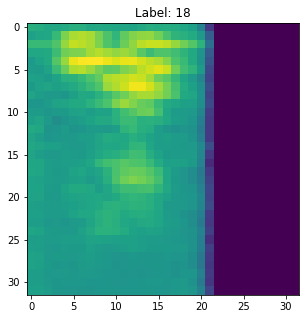

In [7]:
class CommandDataset(torch.utils.data.Dataset):

    def __init__(self):
        paths = ["Dataset/data-speech_commands_v0.02/zero/",
                 "Dataset/data-speech_commands_v0.02/one/",
                 "Dataset/data-speech_commands_v0.02/two/",
                 "Dataset/data-speech_commands_v0.02/three/",
                 "Dataset/data-speech_commands_v0.02/four/",
                 "Dataset/data-speech_commands_v0.02/five/",
                 "Dataset/data-speech_commands_v0.02/six/",
                 "Dataset/data-speech_commands_v0.02/seven/",
                 "Dataset/data-speech_commands_v0.02/eight/",
                 "Dataset/data-speech_commands_v0.02/nine/",

                 "Dataset/data-speech_commands_v0.02/forward/",
                 "Dataset/data-speech_commands_v0.02/backward/",
                 "Dataset/data-speech_commands_v0.02/left/",
                 "Dataset/data-speech_commands_v0.02/right/",
                 "Dataset/data-speech_commands_v0.02/up/",
                 "Dataset/data-speech_commands_v0.02/down/",

                 "Dataset/customUnicornn/create/",
                 "Dataset/customUnicornn/delete/",
                 "Dataset/customUnicornn/select/",
                 "Dataset/customUnicornn/move/",
                 "Dataset/customUnicornn/color/",

                 "Dataset/customUnicornn/red/",
                 "Dataset/customUnicornn/green/",
                 "Dataset/customUnicornn/blue/",
                 "Dataset/customUnicornn/white/",

                 "Dataset/customUnicornn/cube/",
                 "Dataset/customUnicornn/sphere/",
                 "Dataset/customUnicornn/plane/",

                 ]
        self.classes = len(paths)

        self.datasetItems = []
        self.exampleIDs = []
        _id = -1
        for _label in range(0,len(paths)):
            for filename in os.listdir(paths[_label]):
                if filename.endswith(".wav"):
                    self.datasetItems.append((os.path.join(paths[_label],filename),_label))
                    _id += 1
            self.exampleIDs.append(_id)

    def __len__(self):
        return len(self.datasetItems)

    def __getitem__(self, idx):
        _image = wave2image(self.datasetItems[idx][0])

        #scale to Range[0;1]
        _min = np.min(_image)
        _image -= _min
        _max = np.max(_image)
        _image /=_max

        return torch.Tensor(_image).unsqueeze(0), self.datasetItems[idx][1], self.datasetItems[idx][0]

commandDataset = CommandDataset()
print("Einträge im Datensatz:", len(commandDataset))

random_idx = random.randint(0, len(commandDataset)-1)
image, label, path = commandDataset[random_idx]
print("Random Element:", path)
show(image,"Label: " + str(label))

Class Examples:


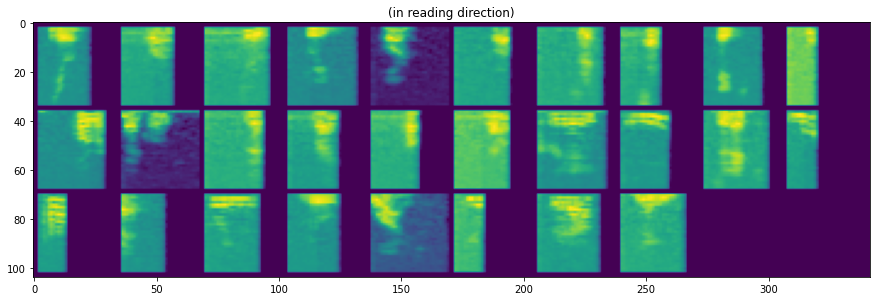

In [8]:
print("Class Examples:")
grid = [commandDataset[i][0] for i in commandDataset.exampleIDs]

grid = torchvision.utils.make_grid(grid, nrow=10, padding=2)
show(grid.numpy(), "(in reading direction)")

### Splitting

Um den Trainingsprozess später evaluieren zu können wird der Datasatz in einen
Trainings- und einen Evaluierungsdatensatz aufgeteilt. Das Verhältnis zwischen den
beiden Datensätzen ist 80:20.

In [9]:
len_ds = len(commandDataset)
len_train = int(0.8*len_ds)
len_val = len_ds - len_train

train_ds, val_ds = torch.utils.data.random_split(commandDataset,[len_train,len_val])

print("Trainingsdaten:", len(train_ds))
print("Evaluierungsdaten:", len(val_ds))

Trainingsdaten: 224
Evaluierungsdaten: 56


### Balance in Datasets

Im Folgenden wird die Verteilung der Einträge nach Label in den verschiedenen Datensätzen
visuell verglichen. Da der Prozess relativ rechenaufwendig ist, kann dieser Abschnitt
übersprungen werden indem die Variable `showDataBalance` auf `False` gesetzt wird.

In [10]:
if showDataBalance == True:

    complete_balance = dataBalance(commandDataset)
    train_balance = dataBalance(train_ds)
    val_balance = dataBalance(val_ds)

    pie_labels = np.arange(commandDataset.classes)

    if len(train_balance) < commandDataset.classes or len(val_balance) < commandDataset.classes:
        print("Datensatz ist zu klein für zufälligen Splitt.\nNicht alle Klassen sind im Train und Test Splitt vertretten.")
    else:
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.pie(complete_balance, labels=pie_labels, counterclock=False, autopct='%1.1f%%',startangle=90,pctdistance=0.8)
        plt.title("Complete Dataset")
        plt.subplot(132)
        plt.pie(train_balance, labels=pie_labels, counterclock=False, autopct='%1.1f%%',startangle=90,pctdistance=0.8)
        plt.title("Train Dataset")
        plt.subplot(133)
        plt.pie(val_balance, labels=pie_labels, counterclock=False, autopct='%1.1f%%',startangle=90,pctdistance=0.8)
        plt.title("Validation Dataset")
        plt.show()
else:
    print("Inorder to plot data balance set showDateBalance=True.")

Datensatz ist zu klein für zufälligen Splitt.
Nicht alle Klassen sind im Train und Test Splitt vertretten.


### DataLoader

`DataLoader` bilden aus den Einträgen in einem Datensatz Batches. Durch `shuffle=True` werden
die Batches aus zufälligen Datensatzeinträgen zusammengestellt. Die Größe der Batches wird durch die Variable
`batchSize` angegeben.

In [11]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batchSize, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batchSize, shuffle=True)

print("Batches im Trainingsdatensatz:",len(train_dl))
print("Batches im Evaluierungsdatensatz:",len(val_dl))

Batches im Trainingsdatensatz: 14
Batches im Evaluierungsdatensatz: 4


## Model

In [12]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.flatten = torch.nn.Flatten()
        self.lin1 = torch.nn.Linear(32*32, 28)

    def forward(self, x):

        x = self.flatten(x)
        x = self.lin1(x)
        return x
        ##return torch.rand(b,commandDataset.classes)


model = CNN().to(device)

### VGG-19 mit Batch Normalisation

In [13]:
model = torchvision.models.vgg19_bn()
model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model.classifier[6] = nn.Linear(in_features=4096, out_features=commandDataset.classes, bias=True)

summary(model, (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

## Training

### Loss-Funktion

Für Multi-Class-Image-Classification wird oft das CrossEntropyLoss verwendet. Pro Batch wird ein
Durchschnittswert berechnet.

In [14]:
loss_func = nn.CrossEntropyLoss(reduction="mean")
loss_hist = []
loss_hist_eval = []

### Metrik

Als Metrik wird pro Batch der prozentuale Anteil der Fälle, in denen die Klassifizierung erfolgreich war,
angegeben.

In [15]:
acc_func = lambda y_real, y_pred:(y_real == y_pred.argmax(1)).sum().item()/batchSize
acc_hist = []
acc_hist_eval = []

### Optimizer

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

### Train-Loop

(Durchläuft zur Demonstration aktuell nur 3 Batches.)

In [17]:
sanity_break = 3;
sanity_counter = 0
for e in range(0,epochs):

    for x, y_real, _ in tqdm(train_dl):

        y_pred = model(x.to(device))

        # print("Real-Label:", y_real)
        # print("Pred-Label:", y_pred.argmax(1))

        accuracy = acc_func(y_real,y_pred)
        acc_hist.append(accuracy)
        print("Accuracy (Train): {0:d}/{1:d} ({2:.4f}%)".format(int(accuracy*batchSize),batchSize,accuracy))

        loss = loss_func(y_pred,y_real)
        loss_hist.append(loss.item())
        print("Loss (Train):",loss.item(),"\n")

        sanity_counter += 1
        if sanity_break == sanity_counter:
            break

    with torch.no_grad():
        for x, y_real, _ in tqdm(val_dl):

            y_pred = model(x.to(device))

            accuracy = acc_func(y_real,y_pred)
            acc_hist_eval.append(accuracy)
            print("Accuracy (Eval): {0:d}/{1:d} ({2:.4f}%)".format(int(accuracy*batchSize),batchSize,accuracy))

            loss = loss_func(y_pred,y_real)
            loss_hist_eval.append(loss.item())
            print("Loss (Eval):",loss.item(),"\n")

 14%|█▍        | 2/14 [00:01<00:08,  1.46it/s]


Real-Label: tensor([12,  2,  7, 19, 20,  3, 10,  7, 24, 14, 11,  3, 20,  4, 22, 27])
Pred-Label: tensor([22, 11, 17, 12, 10, 18, 10, 15, 22, 17, 22, 20,  2,  6, 10,  6],
       grad_fn=<NotImplemented>)
Accuracy: 1/16 (0.0625%)
Loss: 3.3853201866149902 

Real-Label: tensor([24, 14, 11, 14, 16, 18,  9,  0, 26,  9, 12, 19,  9,  7, 20, 25])
Pred-Label: tensor([15, 17, 19, 21, 11,  6, 17, 24, 15,  7, 17, 12, 17, 17, 22, 18],
       grad_fn=<NotImplemented>)
Accuracy: 0/16 (0.0000%)
Loss: 3.8570284843444824 

Real-Label: tensor([18,  0, 15, 17,  4, 11, 15,  6, 12,  8, 22, 17, 15, 21, 24, 25])
Pred-Label: tensor([11, 17, 10, 17,  6, 12, 26,  5, 23, 11, 12, 21,  6, 10, 24, 24],
       grad_fn=<NotImplemented>)
Accuracy: 2/16 (0.1250%)
Loss: 3.3604438304901123 



### Loss- und Accuracy-Plot

(Aktuell: Loss und Accuracy der 3 durchlaufenen Batches.)

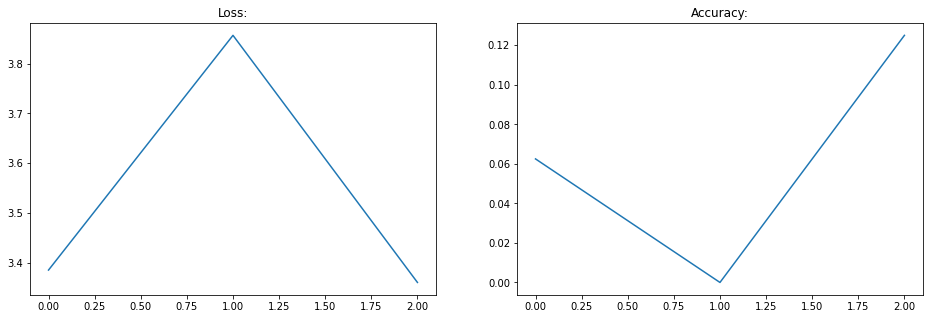

In [18]:
plt.figure(figsize=(16, 5))
plt.subplot(121)  #sublot(Anzahl Zeilen Anzahl Spalten Bild Nummer)
plt.plot(loss_hist)
plt.title('Loss:')

plt.subplot(122)  #sublot(Anzahl Zeilen Anzahl Spalten Bild Nummer)
plt.plot(acc_hist)
plt.title('Accuracy:')
plt.show()

## ONNX-Export

Um das trainierte Netz in Unity nutzen zu können wird vsl. das Barracuda Package
von Unity verwendet. Dieses kann Netze, die im ONNX-Format gespeichert sind, ausführen.

In [19]:
dummy_input = torch.randn(16, 1, 32, 32, device=device)
torch.onnx.export(model, dummy_input, "Unicornn.onnx", verbose=True)

/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/onnx/symbolic_helper.py:176: UserWarning: ONNX export failed on adaptive_avg_pool2d because output size that are not factor of input size not supported
  warnings.warn("ONNX export failed on " + op + " because " + msg + " not supported")


graph(%input.1 : Float(16, 1, 32, 32),
      %features.0.weight : Float(64, 1, 3, 3),
      %features.0.bias : Float(64),
      %features.1.weight : Float(64),
      %features.1.bias : Float(64),
      %features.1.running_mean : Float(64),
      %features.1.running_var : Float(64),
      %features.3.weight : Float(64, 64, 3, 3),
      %features.3.bias : Float(64),
      %features.4.weight : Float(64),
      %features.4.bias : Float(64),
      %features.4.running_mean : Float(64),
      %features.4.running_var : Float(64),
      %features.7.weight : Float(128, 64, 3, 3),
      %features.7.bias : Float(128),
      %features.8.weight : Float(128),
      %features.8.bias : Float(128),
      %features.8.running_mean : Float(128),
      %features.8.running_var : Float(128),
      %features.10.weight : Float(128, 128, 3, 3),
      %features.10.bias : Float(128),
      %features.11.weight : Float(128),
      %features.11.bias : Float(128),
      %features.11.running_mean : Float(128),
      %f

RuntimeError: ONNX export failed: Couldn't export operator aten::adaptive_avg_pool2d

Defined at:
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py(889): adaptive_avg_pool2d
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/pooling.py(1028): forward
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/module.py(534): _slow_forward
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/module.py(548): __call__
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torchvision/models/vgg.py(44): forward
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/module.py(534): _slow_forward
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/module.py(548): __call__
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/jit/__init__.py(348): wrapper
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/jit/__init__.py(361): forward
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/module.py(550): __call__
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/jit/__init__.py(278): _get_trace_graph
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/onnx/utils.py(291): _trace_and_get_graph_from_model
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/onnx/utils.py(334): _model_to_graph
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/onnx/utils.py(488): _export
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/onnx/utils.py(69): export
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/onnx/__init__.py(168): export
<ipython-input-19-ba9cdcb9ce95>(2): <module>
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3331): run_code
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3254): run_ast_nodes
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3063): run_cell_async
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/IPython/core/async_helpers.py(68): _pseudo_sync_runner
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2886): _run_cell
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2858): run_cell
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/ipykernel/zmqshell.py(536): run_cell
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py(300): do_execute
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/tornado/gen.py(209): wrapper
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(545): execute_request
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/tornado/gen.py(209): wrapper
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(268): dispatch_shell
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/tornado/gen.py(209): wrapper
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(365): process_one
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/tornado/gen.py(748): run
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/tornado/gen.py(714): __init__
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/tornado/gen.py(225): wrapper
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(381): dispatch_queue
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/tornado/gen.py(748): run
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/tornado/gen.py(787): inner
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/tornado/ioloop.py(743): _run_callback
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/tornado/ioloop.py(690): <lambda>
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/events.py(88): _run
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/base_events.py(1771): _run_once
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/base_events.py(534): run_forever
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/tornado/platform/asyncio.py(149): start
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/ipykernel/kernelapp.py(597): start
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/traitlets/config/application.py(664): launch_instance
/Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/ipykernel_launcher.py(16): <module>
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py(85): _run_code
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py(193): _run_module_as_main


Graph we tried to export:
graph(%input.1 : Float(16, 1, 32, 32),
      %features.0.weight : Float(64, 1, 3, 3),
      %features.0.bias : Float(64),
      %features.1.weight : Float(64),
      %features.1.bias : Float(64),
      %features.1.running_mean : Float(64),
      %features.1.running_var : Float(64),
      %features.3.weight : Float(64, 64, 3, 3),
      %features.3.bias : Float(64),
      %features.4.weight : Float(64),
      %features.4.bias : Float(64),
      %features.4.running_mean : Float(64),
      %features.4.running_var : Float(64),
      %features.7.weight : Float(128, 64, 3, 3),
      %features.7.bias : Float(128),
      %features.8.weight : Float(128),
      %features.8.bias : Float(128),
      %features.8.running_mean : Float(128),
      %features.8.running_var : Float(128),
      %features.10.weight : Float(128, 128, 3, 3),
      %features.10.bias : Float(128),
      %features.11.weight : Float(128),
      %features.11.bias : Float(128),
      %features.11.running_mean : Float(128),
      %features.11.running_var : Float(128),
      %features.14.weight : Float(256, 128, 3, 3),
      %features.14.bias : Float(256),
      %features.15.weight : Float(256),
      %features.15.bias : Float(256),
      %features.15.running_mean : Float(256),
      %features.15.running_var : Float(256),
      %features.17.weight : Float(256, 256, 3, 3),
      %features.17.bias : Float(256),
      %features.18.weight : Float(256),
      %features.18.bias : Float(256),
      %features.18.running_mean : Float(256),
      %features.18.running_var : Float(256),
      %features.20.weight : Float(256, 256, 3, 3),
      %features.20.bias : Float(256),
      %features.21.weight : Float(256),
      %features.21.bias : Float(256),
      %features.21.running_mean : Float(256),
      %features.21.running_var : Float(256),
      %features.23.weight : Float(256, 256, 3, 3),
      %features.23.bias : Float(256),
      %features.24.weight : Float(256),
      %features.24.bias : Float(256),
      %features.24.running_mean : Float(256),
      %features.24.running_var : Float(256),
      %features.27.weight : Float(512, 256, 3, 3),
      %features.27.bias : Float(512),
      %features.28.weight : Float(512),
      %features.28.bias : Float(512),
      %features.28.running_mean : Float(512),
      %features.28.running_var : Float(512),
      %features.30.weight : Float(512, 512, 3, 3),
      %features.30.bias : Float(512),
      %features.31.weight : Float(512),
      %features.31.bias : Float(512),
      %features.31.running_mean : Float(512),
      %features.31.running_var : Float(512),
      %features.33.weight : Float(512, 512, 3, 3),
      %features.33.bias : Float(512),
      %features.34.weight : Float(512),
      %features.34.bias : Float(512),
      %features.34.running_mean : Float(512),
      %features.34.running_var : Float(512),
      %features.36.weight : Float(512, 512, 3, 3),
      %features.36.bias : Float(512),
      %features.37.weight : Float(512),
      %features.37.bias : Float(512),
      %features.37.running_mean : Float(512),
      %features.37.running_var : Float(512),
      %features.40.weight : Float(512, 512, 3, 3),
      %features.40.bias : Float(512),
      %features.41.weight : Float(512),
      %features.41.bias : Float(512),
      %features.41.running_mean : Float(512),
      %features.41.running_var : Float(512),
      %features.43.weight : Float(512, 512, 3, 3),
      %features.43.bias : Float(512),
      %features.44.weight : Float(512),
      %features.44.bias : Float(512),
      %features.44.running_mean : Float(512),
      %features.44.running_var : Float(512),
      %features.46.weight : Float(512, 512, 3, 3),
      %features.46.bias : Float(512),
      %features.47.weight : Float(512),
      %features.47.bias : Float(512),
      %features.47.running_mean : Float(512),
      %features.47.running_var : Float(512),
      %features.49.weight : Float(512, 512, 3, 3),
      %features.49.bias : Float(512),
      %features.50.weight : Float(512),
      %features.50.bias : Float(512),
      %features.50.running_mean : Float(512),
      %features.50.running_var : Float(512),
      %classifier.0.weight : Float(4096, 25088),
      %classifier.0.bias : Float(4096),
      %classifier.3.weight : Float(4096, 4096),
      %classifier.3.bias : Float(4096),
      %classifier.6.weight : Float(28, 4096),
      %classifier.6.bias : Float(28)):
  %119 : Float(16, 64, 32, 32) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%input.1, %features.0.weight, %features.0.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/conv.py:346:0
  %120 : Float(16, 64, 32, 32) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%119, %features.1.weight, %features.1.bias, %features.1.running_mean, %features.1.running_var) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1923:0
  %121 : Float(16, 64, 32, 32) = onnx::Relu(%120) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1061:0
  %122 : Float(16, 64, 32, 32) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%121, %features.3.weight, %features.3.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/conv.py:346:0
  %123 : Float(16, 64, 32, 32) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%122, %features.4.weight, %features.4.bias, %features.4.running_mean, %features.4.running_var) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1923:0
  %124 : Float(16, 64, 32, 32) = onnx::Relu(%123) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1061:0
  %125 : Float(16, 64, 16, 16) = onnx::MaxPool[kernel_shape=[2, 2], pads=[0, 0, 0, 0], strides=[2, 2]](%124) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:539:0
  %126 : Float(16, 128, 16, 16) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%125, %features.7.weight, %features.7.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/conv.py:346:0
  %127 : Float(16, 128, 16, 16) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%126, %features.8.weight, %features.8.bias, %features.8.running_mean, %features.8.running_var) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1923:0
  %128 : Float(16, 128, 16, 16) = onnx::Relu(%127) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1061:0
  %129 : Float(16, 128, 16, 16) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%128, %features.10.weight, %features.10.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/conv.py:346:0
  %130 : Float(16, 128, 16, 16) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%129, %features.11.weight, %features.11.bias, %features.11.running_mean, %features.11.running_var) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1923:0
  %131 : Float(16, 128, 16, 16) = onnx::Relu(%130) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1061:0
  %132 : Float(16, 128, 8, 8) = onnx::MaxPool[kernel_shape=[2, 2], pads=[0, 0, 0, 0], strides=[2, 2]](%131) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:539:0
  %133 : Float(16, 256, 8, 8) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%132, %features.14.weight, %features.14.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/conv.py:346:0
  %134 : Float(16, 256, 8, 8) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%133, %features.15.weight, %features.15.bias, %features.15.running_mean, %features.15.running_var) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1923:0
  %135 : Float(16, 256, 8, 8) = onnx::Relu(%134) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1061:0
  %136 : Float(16, 256, 8, 8) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%135, %features.17.weight, %features.17.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/conv.py:346:0
  %137 : Float(16, 256, 8, 8) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%136, %features.18.weight, %features.18.bias, %features.18.running_mean, %features.18.running_var) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1923:0
  %138 : Float(16, 256, 8, 8) = onnx::Relu(%137) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1061:0
  %139 : Float(16, 256, 8, 8) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%138, %features.20.weight, %features.20.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/conv.py:346:0
  %140 : Float(16, 256, 8, 8) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%139, %features.21.weight, %features.21.bias, %features.21.running_mean, %features.21.running_var) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1923:0
  %141 : Float(16, 256, 8, 8) = onnx::Relu(%140) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1061:0
  %142 : Float(16, 256, 8, 8) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%141, %features.23.weight, %features.23.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/conv.py:346:0
  %143 : Float(16, 256, 8, 8) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%142, %features.24.weight, %features.24.bias, %features.24.running_mean, %features.24.running_var) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1923:0
  %144 : Float(16, 256, 8, 8) = onnx::Relu(%143) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1061:0
  %145 : Float(16, 256, 4, 4) = onnx::MaxPool[kernel_shape=[2, 2], pads=[0, 0, 0, 0], strides=[2, 2]](%144) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:539:0
  %146 : Float(16, 512, 4, 4) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%145, %features.27.weight, %features.27.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/conv.py:346:0
  %147 : Float(16, 512, 4, 4) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%146, %features.28.weight, %features.28.bias, %features.28.running_mean, %features.28.running_var) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1923:0
  %148 : Float(16, 512, 4, 4) = onnx::Relu(%147) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1061:0
  %149 : Float(16, 512, 4, 4) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%148, %features.30.weight, %features.30.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/conv.py:346:0
  %150 : Float(16, 512, 4, 4) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%149, %features.31.weight, %features.31.bias, %features.31.running_mean, %features.31.running_var) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1923:0
  %151 : Float(16, 512, 4, 4) = onnx::Relu(%150) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1061:0
  %152 : Float(16, 512, 4, 4) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%151, %features.33.weight, %features.33.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/conv.py:346:0
  %153 : Float(16, 512, 4, 4) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%152, %features.34.weight, %features.34.bias, %features.34.running_mean, %features.34.running_var) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1923:0
  %154 : Float(16, 512, 4, 4) = onnx::Relu(%153) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1061:0
  %155 : Float(16, 512, 4, 4) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%154, %features.36.weight, %features.36.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/conv.py:346:0
  %156 : Float(16, 512, 4, 4) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%155, %features.37.weight, %features.37.bias, %features.37.running_mean, %features.37.running_var) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1923:0
  %157 : Float(16, 512, 4, 4) = onnx::Relu(%156) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1061:0
  %158 : Float(16, 512, 2, 2) = onnx::MaxPool[kernel_shape=[2, 2], pads=[0, 0, 0, 0], strides=[2, 2]](%157) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:539:0
  %159 : Float(16, 512, 2, 2) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%158, %features.40.weight, %features.40.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/conv.py:346:0
  %160 : Float(16, 512, 2, 2) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%159, %features.41.weight, %features.41.bias, %features.41.running_mean, %features.41.running_var) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1923:0
  %161 : Float(16, 512, 2, 2) = onnx::Relu(%160) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1061:0
  %162 : Float(16, 512, 2, 2) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%161, %features.43.weight, %features.43.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/conv.py:346:0
  %163 : Float(16, 512, 2, 2) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%162, %features.44.weight, %features.44.bias, %features.44.running_mean, %features.44.running_var) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1923:0
  %164 : Float(16, 512, 2, 2) = onnx::Relu(%163) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1061:0
  %165 : Float(16, 512, 2, 2) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%164, %features.46.weight, %features.46.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/conv.py:346:0
  %166 : Float(16, 512, 2, 2) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%165, %features.47.weight, %features.47.bias, %features.47.running_mean, %features.47.running_var) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1923:0
  %167 : Float(16, 512, 2, 2) = onnx::Relu(%166) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1061:0
  %168 : Float(16, 512, 2, 2) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%167, %features.49.weight, %features.49.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/modules/conv.py:346:0
  %169 : Float(16, 512, 2, 2) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%168, %features.50.weight, %features.50.bias, %features.50.running_mean, %features.50.running_var) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1923:0
  %170 : Float(16, 512, 2, 2) = onnx::Relu(%169) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1061:0
  %171 : Float(16, 512, 1, 1) = onnx::MaxPool[kernel_shape=[2, 2], pads=[0, 0, 0, 0], strides=[2, 2]](%170) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:539:0
  %172 : int[] = onnx::Constant[value= 7  7 [ CPULongType{2} ]]()
  %173 : Float(16, 512, 7, 7) = aten::adaptive_avg_pool2d(%171, %172) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:889:0
  %174 : Float(16, 25088) = onnx::Flatten[axis=1](%173) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torchvision/models/vgg.py:45:0
  %175 : Float(16, 4096) = onnx::Gemm[alpha=1., beta=1., transB=1](%174, %classifier.0.weight, %classifier.0.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1610:0
  %176 : Float(16, 4096) = onnx::Relu(%175) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:936:0
  %177 : Float(16, 4096) = onnx::Gemm[alpha=1., beta=1., transB=1](%176, %classifier.3.weight, %classifier.3.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1610:0
  %178 : Float(16, 4096) = onnx::Relu(%177) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:936:0
  %179 : Float(16, 28) = onnx::Gemm[alpha=1., beta=1., transB=1](%178, %classifier.6.weight, %classifier.6.bias) # /Users/alexander/Documents/Python-Projects/Unicornn/venv/lib/python3.7/site-packages/torch/nn/functional.py:1610:0
  return (%179)


## Deployment Simulation

Der folgende Ablauf findet später in Unity mit Barracuda statt.

In [ ]:
classified = []
for i in range(300):
    pred = model(torch.randn(1, 1, 32, 32, device=device)).argmax(1).item()
    if pred != commandDataset.classes:
        classified.append(pred)

    if 16 in classified and 25 in classified:
        print("Create Cube")
        classified = []
    if 16 in classified and 26 in classified:
        print("Create Sphere")
        classified = []
    if 16 in classified and 27 in classified:
        print("Create Plane")
        classified = []

### Vorhersage für leere Textur zum Vergleich mit Barracuda-Ergebnis in Unity

In [ ]:
print("PredictedClass für leere Textur:", model(torch.ones([1,1,32,32], device=device)).argmax(1).item())